## BANK MARKETING CAMPAIGN - MACHINE LEARNING

Data taken from : https://archive.ics.uci.edu/ml/datasets/bank+marketing

In this section we will try to find the best and proper model to predict the clients who're deposited and not deposited. This data related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold , cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

import scipy.stats as ss
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity
from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import anderson

from yellowbrick.model_selection import learning_curve, ValidationCurve

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=FutureWarning)

C:\Users\cahya\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### OVERVIEW

In [2]:
df = pd.read_csv('bank_ready.csv')

In [3]:
df.head()

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
0,59,2343,5,1042,1,0,0,admin.,married,secondary,no,yes,no,unknown,may,unknown,yes
1,56,45,5,1467,1,0,0,admin.,married,secondary,no,no,no,unknown,may,unknown,yes
2,41,1270,5,1389,1,0,0,technician,married,secondary,no,yes,no,unknown,may,unknown,yes
3,55,2476,5,579,1,0,0,services,married,secondary,no,yes,no,unknown,may,unknown,yes
4,54,184,5,673,2,0,0,admin.,married,tertiary,no,no,no,unknown,may,unknown,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   balance    11162 non-null  int64 
 2   day        11162 non-null  int64 
 3   duration   11162 non-null  int64 
 4   campaign   11162 non-null  int64 
 5   pdays      11162 non-null  int64 
 6   previous   11162 non-null  int64 
 7   job        11162 non-null  object
 8   marital    11162 non-null  object
 9   education  11162 non-null  object
 10  default    11162 non-null  object
 11  housing    11162 non-null  object
 12  loan       11162 non-null  object
 13  contact    11162 non-null  object
 14  month      11162 non-null  object
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [5]:
pd.DataFrame({'Features' : df.columns, 'dataType' : df.dtypes.values, 
              'nullvalues' : [df[i].isna().sum() for i in df.columns],
              'unique' : [df[i].nunique() for i in df.columns],
              'uniqueSample' : [list(pd.Series(df[i].unique()).sample(2)) for i in df.columns]}).reset_index(drop = True)

,Features,dataType,nullvalues,unique,uniqueSample
0,age,int64,0,76,"[22, 88]"
1,balance,int64,0,3805,"[463, 7119]"
2,day,int64,0,31,"[22, 4]"
3,duration,int64,0,1428,"[958, 262]"
4,campaign,int64,0,36,"[63, 4]"
5,pdays,int64,0,472,"[178, 86]"
6,previous,int64,0,34,"[12, 7]"
7,job,object,0,12,"[unknown, unemployed]"
8,marital,object,0,3,"[divorced, single]"
9,education,object,0,4,"[tertiary, primary]"


> I'll split the data into two categories for easier indexing.

In [6]:
df_cat = df.select_dtypes(['object'])

In [7]:
df_cat.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
0,admin.,married,secondary,no,yes,no,unknown,may,unknown,yes
1,admin.,married,secondary,no,no,no,unknown,may,unknown,yes
2,technician,married,secondary,no,yes,no,unknown,may,unknown,yes
3,services,married,secondary,no,yes,no,unknown,may,unknown,yes
4,admin.,married,tertiary,no,no,no,unknown,may,unknown,yes


In [8]:
df_con = df.select_dtypes(['float64', 'int64'])

In [9]:
df_con.head()

,age,balance,day,duration,campaign,pdays,previous
0,59,2343,5,1042,1,0,0
1,56,45,5,1467,1,0,0
2,41,1270,5,1389,1,0,0
3,55,2476,5,579,1,0,0
4,54,184,5,673,2,0,0


> Now we continue to do Feature Engineering, but before we do anything further, let's double check for normality and outliers. 

### FEATURE ENGINEERING

#### NORMALITY AND OUTLIER CHECK

In [10]:
def normal(df):
    
    stat = anderson(df)[0]
    cval = anderson(df)[1][2]
    if stat < cval :
        print('NORMALLY Distributed for ' + i + ' Variable')
    else :
        print('NOT NORMALLY Distributed for ' + i + ' Variable')

In [11]:
for i in df_con.columns :
    normal(df_con[i])

NOT NORMALLY Distributed for age Variable
NOT NORMALLY Distributed for balance Variable
NOT NORMALLY Distributed for day Variable
NOT NORMALLY Distributed for duration Variable
NOT NORMALLY Distributed for campaign Variable
NOT NORMALLY Distributed for pdays Variable
NOT NORMALLY Distributed for previous Variable


<Figure size 864x360 with 0 Axes>

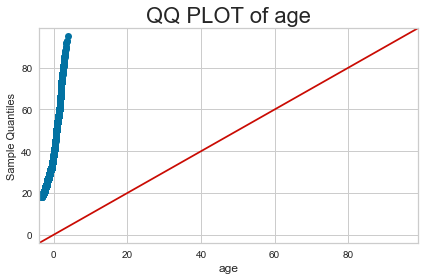

<Figure size 864x360 with 0 Axes>

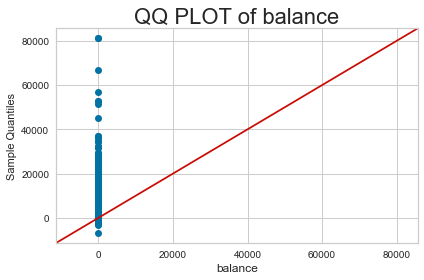

<Figure size 864x360 with 0 Axes>

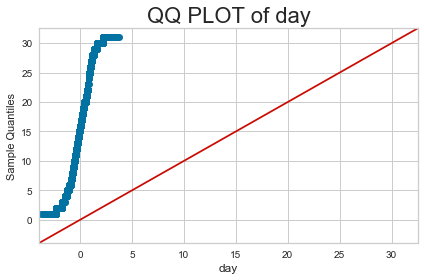

<Figure size 864x360 with 0 Axes>

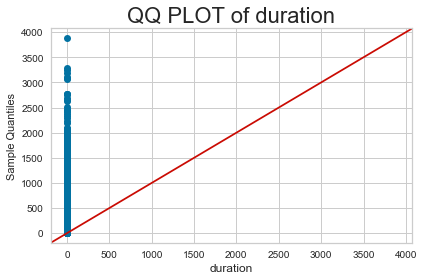

<Figure size 864x360 with 0 Axes>

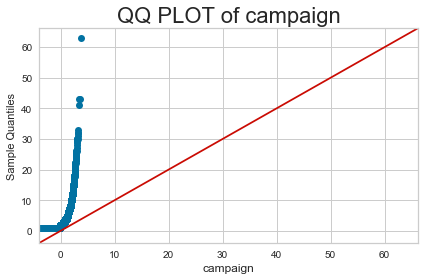

<Figure size 864x360 with 0 Axes>

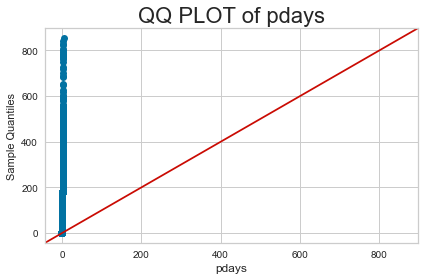

<Figure size 864x360 with 0 Axes>

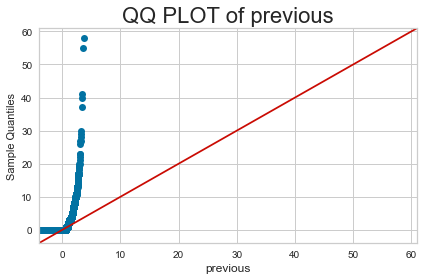

In [12]:
for col in df_con.columns :
    
    plt.figure(figsize = (12,5))
    
    sm.qqplot(df[col], line = '45')
    plt.xlabel(col, fontsize = 12)
    plt.title('QQ PLOT of ' + col, fontsize = 22)
    
    plt.tight_layout()
    plt.show()

> All of the continous features are not normally distributed.

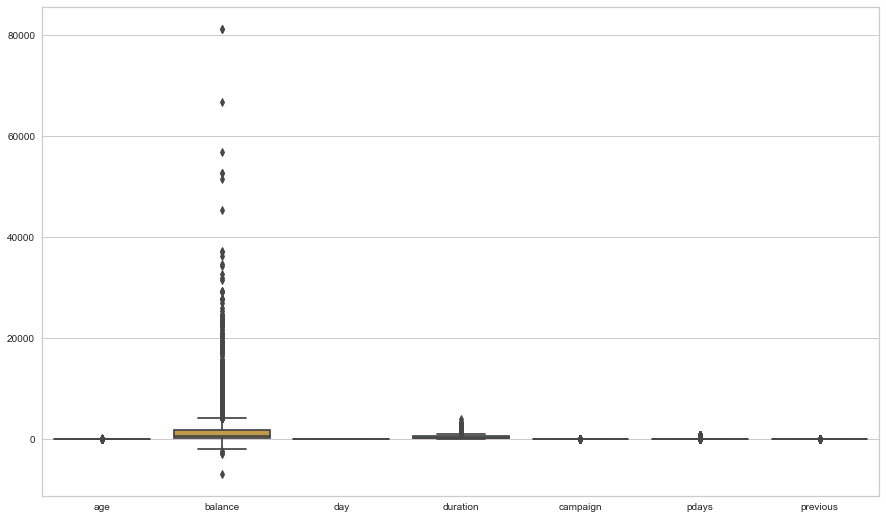

In [13]:
plt.figure(figsize = (15,9))
sns.boxplot(data=df_con)
plt.show()

> From plot above we can see that the data are rather not on the same scale, also this data contained many outliers. I'll show the indicated outliers below.

In [14]:
def outliers(df):
    Q2 = np.quantile(df, 0.50)
    Q1 = np.quantile(df, 0.25)
    Q3 = np.quantile(df, 0.75)
    
    IQR   = (Q3 - Q1) * 1.5
    lower =  Q1 - IQR
    upper =  Q3 + IQR 

    outlier = ''
    for i in range(len(df)):
        if df[i] > upper :
            outlier = outlier + str(df[i]) + ', '
        if df[i] < lower :
            outlier = outlier + str(df[i]) + ', '
    return len(outlier)

In [15]:
for i in df_con.columns:
    outlier = outliers(df_con[i])
    print(f'There are {outlier} Outliers on {i} Features')

There are 684 Outliers on age Features
There are 6562 Outliers on balance Features
There are 0 Outliers on day Features
There are 3816 Outliers on duration Features
There are 2065 Outliers on campaign Features
There are 13108 Outliers on pdays Features
There are 3900 Outliers on previous Features


#### LABELLING

> We will label the data by splitting the categorical features into two categories - Nominal data and Ordinal data.

In [16]:
df_ready = df.copy()

In [17]:
df_ready_cat = df_ready.select_dtypes(['object'])
df_ready_con = df_ready.select_dtypes(['float64', 'int64'])

In [18]:
# ordinal datatype

df_ord = df_ready_cat[['education', 'deposit', 'poutcome']]

# nominal datatype

df_nom = df_ready_cat.drop(df_ord, axis = 'columns')

In [19]:
df_ord.head()

,education,deposit,poutcome
0,secondary,yes,unknown
1,secondary,yes,unknown
2,secondary,yes,unknown
3,secondary,yes,unknown
4,tertiary,yes,unknown


In [20]:
df_nom.head()

,job,marital,default,housing,loan,contact,month
0,admin.,married,no,yes,no,unknown,may
1,admin.,married,no,no,no,unknown,may
2,technician,married,no,yes,no,unknown,may
3,services,married,no,yes,no,unknown,may
4,admin.,married,no,no,no,unknown,may


> We will use `LabelEncoder()` on the ordinal, and `pd.get_dummies()` on numerical data.

In [21]:
for i in df_ord.columns :
    encoder = LabelEncoder()
    df_ord[i] = encoder.fit_transform(df_ord[i])

In [22]:
df_ord.head()

,education,deposit,poutcome
0,1,1,3
1,1,1,3
2,1,1,3
3,1,1,3
4,2,1,3


In [23]:
for i in df_nom.columns :
    df_nom = pd.get_dummies(df_nom, drop_first = True)

In [24]:
df_nom.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [25]:
df_ready_cat = pd.concat([df_ord, df_nom], axis = 1)

> Afterwards, we concat the data to new dataframe and start doing feature selection.

In [26]:
df_ready = pd.concat([df_ready_con, df_ready_cat], axis = 1)

In [27]:
df_ready.head()

,age,balance,day,duration,campaign,pdays,previous,education,deposit,poutcome,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,59,2343,5,1042,1,0,0,1,1,3,...,0,0,0,0,0,0,1,0,0,0
1,56,45,5,1467,1,0,0,1,1,3,...,0,0,0,0,0,0,1,0,0,0
2,41,1270,5,1389,1,0,0,1,1,3,...,0,0,0,0,0,0,1,0,0,0
3,55,2476,5,579,1,0,0,1,1,3,...,0,0,0,0,0,0,1,0,0,0
4,54,184,5,673,2,0,0,2,1,3,...,0,0,0,0,0,0,1,0,0,0


#### SPLIT DATA FOR FEATURE IMPORTANCE

In [28]:
X = df_ready.drop(['deposit'], axis = 1)
y = df_ready['deposit']

#### FEATURE IMPORTANCE - CORRELATION

In [29]:
#Correlation measurement between discrete and continous features

def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

#Correlation measurement between categorical features

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

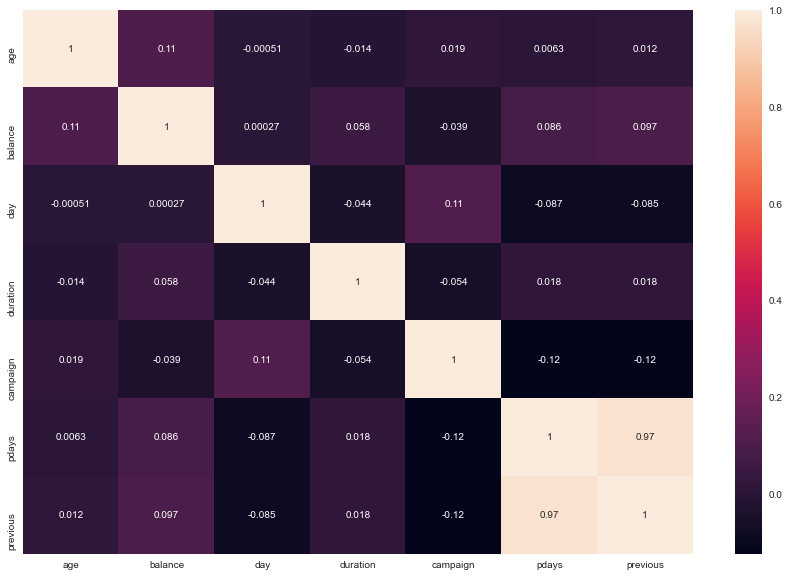

In [30]:
#Correlation measurement between continous features

plt.figure(figsize = (15,10))
sns.heatmap(df_con.corr('spearman'), annot = True)

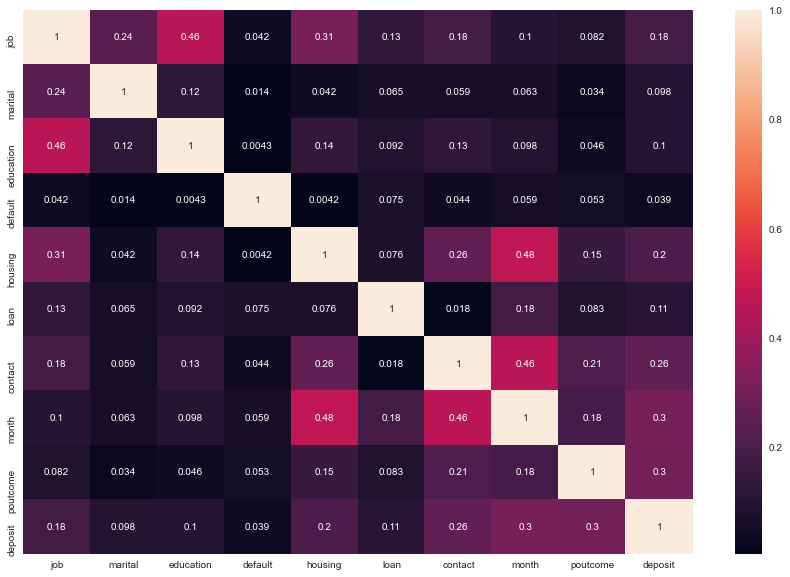

In [31]:
corr = []

for i in df_cat.columns:
    mat = []
    for j in df_cat.columns:
        mat.append(cramers_v(df_cat[i],df_cat[j]))
    corr.append(mat)
    
cramers = pd.DataFrame(corr, index = df_cat.columns, columns = df_cat.columns)
plt.figure(figsize = (15,10))
sns.heatmap(cramers,annot = True)

In [32]:
corr = []

for i in df_cat.columns:
    mat = []
    for j in df_con.columns:
        mat.append(correlation_ratio(df[i], df[j]))
    corr.append(mat)
    
cramers = pd.DataFrame(corr, index = df_cat.columns, columns = df_con.columns)

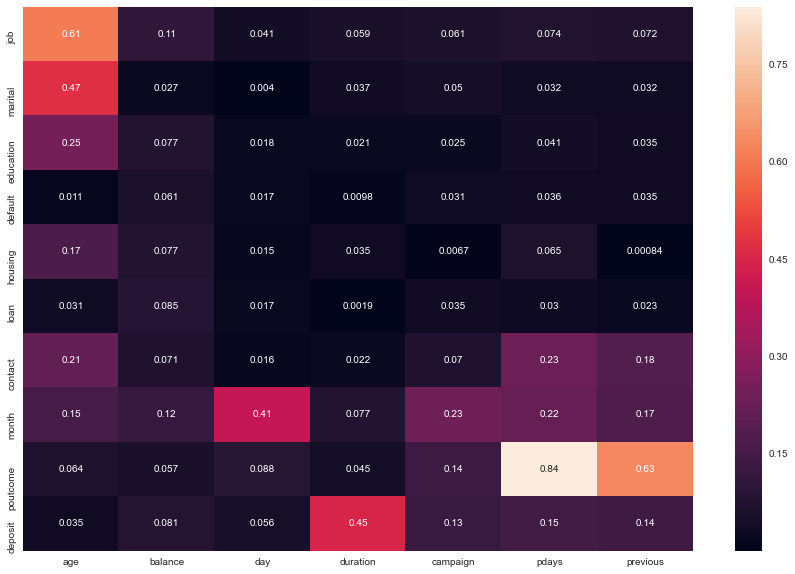

In [33]:
plt.figure(figsize = (15,10))
sns.heatmap(cramers, annot = True)

> We can manually get our best feature using correlation method. But it's better if we use *Tree Based Classifier* to extract best feature.

#### FEATURE IMPORTANCE - TREE BASED CLASSIFIER

[0.07147813 0.07145267 0.07795421 0.26723214 0.05026604 0.03107529
 0.02042985 0.03286223 0.04110301 0.01072741 0.00512207 0.00428972
 0.0124568  0.00803349 0.00600692 0.00849688 0.00612491 0.01262802
 0.00552151 0.00167452 0.01373062 0.01181817 0.00335904 0.03119412
 0.01523199 0.01055112 0.04501535 0.01584215 0.0036721  0.00924742
 0.00824913 0.01251016 0.01250098 0.01319165 0.01612139 0.01087546
 0.01248956 0.00946376]


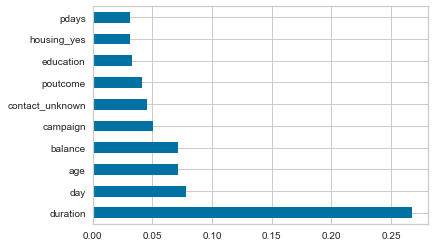

In [34]:
# feature importances using Tree Based Classifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)

# plot graph of feature importances for better visualization

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

> Alhough it's basically the same, we use this method for better visualization and automation.

In [35]:
feat_col = feat_importances.nlargest(10).index.tolist()
feat_tgt = pd.DataFrame(df_ready['deposit'])

In [36]:
df_new = pd.concat([df_ready[feat_col], feat_tgt], axis=1)

In [37]:
df_new.head()

,duration,day,age,balance,campaign,contact_unknown,poutcome,education,housing_yes,pdays,deposit
0,1042,5,59,2343,1,1,3,1,1,0,1
1,1467,5,56,45,1,1,3,1,0,0,1
2,1389,5,41,1270,1,1,3,1,1,0,1
3,579,5,55,2476,1,1,3,1,1,0,1
4,673,5,54,184,2,1,3,2,0,0,1


In [38]:
df_new.to_csv('bank_HP.csv', index = False)

#### SPLIT DATA FOR MODELLING

In [39]:
X = df_new.drop(['deposit'], axis = 1)
y = df_new['deposit']

In [40]:
print(X, y)

       duration  day  age  balance  campaign  contact_unknown  poutcome  \
0          1042    5   59     2343         1                1         3   
1          1467    5   56       45         1                1         3   
2          1389    5   41     1270         1                1         3   
3           579    5   55     2476         1                1         3   
4           673    5   54      184         2                1         3   
...         ...  ...  ...      ...       ...              ...       ...   
11157       257   20   33        1         1                0         3   
11158        83   16   39      733         4                1         3   
11159       156   19   32       29         2                0         3   
11160         9    8   43        0         2                0         0   
11161       628    9   34        0         1                0         3   

       education  housing_yes  pdays  
0              1            1      0  
1              1     

In [41]:
#Split train data 80%, test data 20%

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 42)

### MODEL PREPARATION

> After we split the data, we will now continue to prepare the model for prediction.

In [42]:
# Random Forest Classifier model with default parameter

RFC = RandomForestClassifier().fit(X_train, y_train)

# Support Vector Machine Classifier with default parameter

SVM = SVC(kernel = 'rbf').fit(X_train, y_train)

In [43]:
# Random Forest Classifier model with previously tuned hyperparameter

hyper_RFC = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, min_samples_leaf = 4, max_depth = 40).fit(X_train, y_train)

# Support Vector Machine Classifier model with previously tuned hyperparameter

hyper_SVM = SVC(kernel='rbf', gamma = 'scale', C = 10).fit(X_train, y_train)

### CROSS VALIDATION

> Now we will examine whether there are overfitting or underfitting on this data using Kfold cross validation method.

In [44]:
# Train data

RFC_score_tr = RFC.score(X_train, y_train)
SVM_score_tr = SVM.score(X_train, y_train)
hyper_RFC_score_tr = hyper_RFC.score(X_train, y_train)
hyper_SVM_score_tr = hyper_SVM.score(X_train, y_train)

In [45]:
# Test data

RFC_score_ts = RFC.score(X_test, y_test)
SVM_score_ts = SVM.score(X_test, y_test)
hyper_RFC_score_ts = hyper_RFC.score(X_test, y_test)
hyper_SVM_score_ts = hyper_SVM.score(X_test, y_test)

In [46]:
train_score = pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                            'Normal': [RFC_score_tr, SVM_score_tr], 
                            'Hyper' : [hyper_RFC_score_tr, hyper_SVM_score_tr]})

In [47]:
test_score = pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                           'Normal': [RFC_score_ts, SVM_score_ts], 
                           'Hyper' : [hyper_RFC_score_ts, hyper_SVM_score_ts]})

In [48]:
pd.concat([train_score, test_score], keys = ['Train Score', 'Test Score'])

Model    Normal     Hyper
Train Score 0   Random Forest  0.999776  0.902453
            1  Support Vector  0.743420  0.750924
Test Score  0   Random Forest  0.802508  0.805643
            1  Support Vector  0.726825  0.737125

> Seeing the differences in the score above, I think there are overfitting on Random Forest default parameter. We'll see it using cross validation.

In [49]:
# Check overfit on default data

cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
RFC_kfold = cross_val_score(RFC, X_train, y_train, cv = cv, scoring = 'accuracy')
SVM_kfold = cross_val_score(SVM, X_train, y_train, cv = cv, scoring = 'accuracy')

pd.DataFrame({'RFC kfold' : RFC_kfold.tolist(),
              'SVM kfold' : SVM_kfold.tolist()})

,RFC kfold,SVM kfold
0,0.837626,0.746920
1,0.812990,0.707727
2,0.821948,0.748040
3,0.833147,0.726764
4,0.828667,0.762598
5,0.826428,0.741321
6,0.842105,0.765957
7,0.809630,0.749160
8,0.845465,0.742441
9,0.800448,0.715247


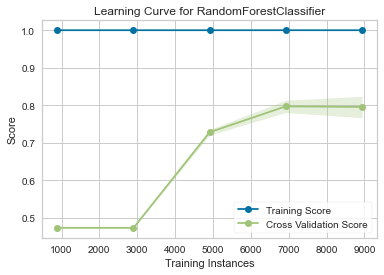

In [50]:
learning_curve(RFC, X, y, scoring='accuracy')
plt.show()

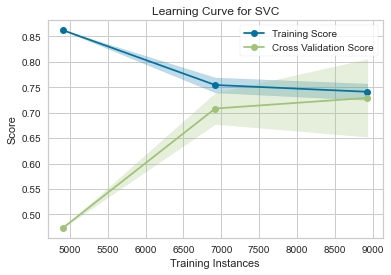

In [51]:
learning_curve(SVM, X, y, scoring='accuracy')
plt.show()

In [52]:
pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                        'Normal': [RFC_score_tr, SVM_score_tr], 
                        'Mean Kfold' : [RFC_kfold.mean(), SVM_kfold.mean()]})

,Model,Normal,Mean Kfold
0,Random Forest,0.999776,0.825846
1,Support Vector,0.743420,0.740618


> We can clearly see the overfitting on Random Forest using default parameter model by seeing the `learning_curve()` and **Kfold Cross Validation above**. Now we examine the hyperparameter tuned model.

In [53]:
# Check overfit on hyperparameter tuned data

cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
hyper_RFC_kfold = cross_val_score(hyper_RFC, X_train, y_train, cv = cv, scoring = 'accuracy')
hyper_SVM_kfold = cross_val_score(hyper_SVM, X_train, y_train, cv = cv, scoring = 'accuracy')

pd.DataFrame({'Hyper RFC kfold' : hyper_RFC_kfold.tolist(),
              'Hyper SVM kfold' : hyper_SVM_kfold.tolist()})

,Hyper RFC kfold,Hyper SVM kfold
0,0.830907,0.750280
1,0.810750,0.718925
2,0.826428,0.759239
3,0.830907,0.737962
4,0.832027,0.760358
5,0.838746,0.742441
6,0.855543,0.781635
7,0.814110,0.750280
8,0.844345,0.756999
9,0.812780,0.718610


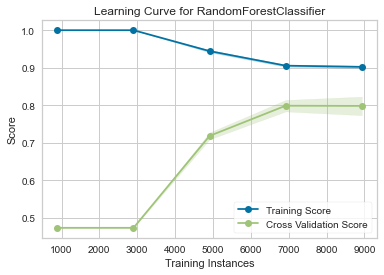

In [54]:
learning_curve(hyper_RFC, X, y, scoring='accuracy')
plt.show()

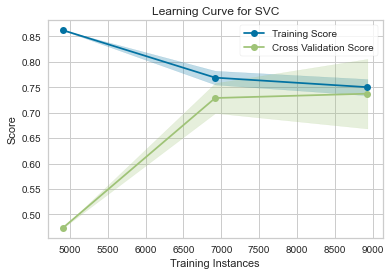

In [55]:
learning_curve(hyper_SVM, X, y, scoring='accuracy')
plt.show()

In [56]:
pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                        'Hyper': [hyper_RFC_score_tr, hyper_SVM_score_tr], 
                        'Mean Kfold' : [hyper_RFC_kfold.mean(), hyper_SVM_kfold.mean()]})

,Model,Hyper,Mean Kfold
0,Random Forest,0.902453,0.829654
1,Support Vector,0.750924,0.747673


> Although there are still some ovefitting on the Random Forest model, but the overfitting are not extreme as before. Therefore I think using hyperparameter tuned model is a better choice, as the Support Vector model also perform better with hyperparameter tuning.

### MODEL PREDICTION AND PERFORMANCE EVALUATION

> We will be using the hyperparameter tuned model, for reasons mentioned before.

In [57]:
# Random Forest Classifier
yp_RFC = hyper_RFC.predict(X_test)

# Support Vector Machine Classifier
yp_SVM = hyper_SVM.predict(X_test)

#### RANDOM FOREST CLASSIFIER

In [58]:
cm_RFC = confusion_matrix(y_test, yp_RFC)
cm_RFC

array([[917, 249],
       [185, 882]], dtype=int64)

In [59]:
labels = ['Default No', 'Default Yes']

              precision    recall  f1-score   support

  Default No       0.83      0.79      0.81      1166
 Default Yes       0.78      0.83      0.80      1067

    accuracy                           0.81      2233
   macro avg       0.81      0.81      0.81      2233
weighted avg       0.81      0.81      0.81      2233



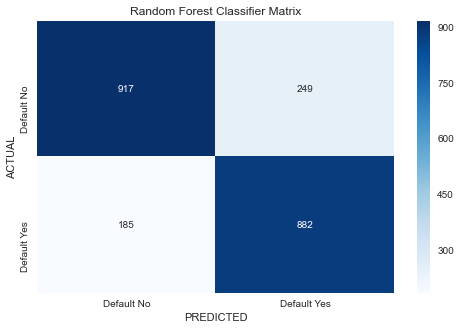

In [60]:
print(classification_report(y_test, yp_RFC, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_RFC, annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Random Forest Classifier Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> This model performed excellent. It can predict both the client who are default and not default.

#### SUPPORT VECTOR MACHINE CLASSIFIER

In [61]:
cm_SVM = confusion_matrix(y_test, yp_SVM)
cm_SVM

array([[911, 255],
       [332, 735]], dtype=int64)

              precision    recall  f1-score   support

  Default No       0.73      0.78      0.76      1166
 Default Yes       0.74      0.69      0.71      1067

    accuracy                           0.74      2233
   macro avg       0.74      0.74      0.74      2233
weighted avg       0.74      0.74      0.74      2233



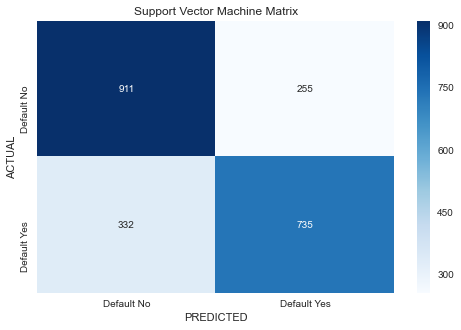

In [62]:
print(classification_report(y_test, yp_SVM, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_SVM, annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Support Vector Machine Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> This model performed good. But Random Forest still hold the better score. Let's experiment more, we'll try to add more features by doing another feature selection.

### FEATURE ENGINEERING - PART 2

#### SPLIT DATA FOR FEATURE IMPORTANCES

In [63]:
X1 = df_ready.drop(['deposit'], axis = 1)
y1 = df_ready['deposit']

#### FEATURE IMPORTANCES - TREE BASED CLASSIFIER

[0.0705994  0.07109896 0.07741441 0.2705944  0.05061378 0.02973542
 0.02039983 0.03316299 0.04096355 0.01101564 0.00506048 0.00427201
 0.0127878  0.00808143 0.00580057 0.00825521 0.00637059 0.01236035
 0.00544725 0.00164949 0.01332736 0.01120032 0.00325981 0.03041891
 0.01572137 0.0101245  0.04569677 0.01513803 0.00378828 0.00967338
 0.00775667 0.01221177 0.01228831 0.01306541 0.01648563 0.01144912
 0.01307546 0.00963534]


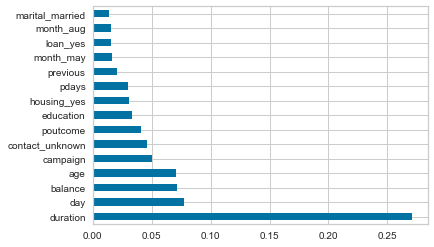

In [64]:
# feature importances using Tree Based Classifier

model = ExtraTreesClassifier()
model.fit(X1,y1)
print(model.feature_importances_)

# plot graph of feature importances for better visualization

feat_importances = pd.Series(model.feature_importances_, index=X1.columns)
feat_importances.nlargest(15).plot(kind = 'barh')
plt.show()

In [65]:
feat_col = feat_importances.nlargest(15).index.tolist()
feat_tgt = pd.DataFrame(df_ready['deposit'])

In [66]:
df_new1 = pd.concat([df_ready[feat_col], feat_tgt], axis=1)

In [67]:
df_new1.head()

,duration,day,balance,age,campaign,contact_unknown,poutcome,education,housing_yes,pdays,previous,month_may,loan_yes,month_aug,marital_married,deposit
0,1042,5,2343,59,1,1,3,1,1,0,0,1,0,0,1,1
1,1467,5,45,56,1,1,3,1,0,0,0,1,0,0,1,1
2,1389,5,1270,41,1,1,3,1,1,0,0,1,0,0,1,1
3,579,5,2476,55,1,1,3,1,1,0,0,1,0,0,1,1
4,673,5,184,54,2,1,3,2,0,0,0,1,0,0,1,1


> Now we've got another set of data. We will do the process all over again, and see the result.

#### SPLIT DATA FOR MODELLING

In [68]:
X1 = df_new1.drop(['deposit'], axis = 1)
y1 = df_new1['deposit']

In [69]:
print(X1, y1)

       duration  day  balance  age  campaign  contact_unknown  poutcome  \
0          1042    5     2343   59         1                1         3   
1          1467    5       45   56         1                1         3   
2          1389    5     1270   41         1                1         3   
3           579    5     2476   55         1                1         3   
4           673    5      184   54         2                1         3   
...         ...  ...      ...  ...       ...              ...       ...   
11157       257   20        1   33         1                0         3   
11158        83   16      733   39         4                1         3   
11159       156   19       29   32         2                0         3   
11160         9    8        0   43         2                0         0   
11161       628    9        0   34         1                0         3   

       education  housing_yes  pdays  previous  month_may  loan_yes  \
0              1            

In [70]:
#Split train data 80%, test data 20%

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size = .8, random_state = 42)

### MODEL PREPARATION - PART 2

In [71]:
# Random Forest Classifier model with default parameter

RFC1 = RandomForestClassifier().fit(X1_train, y1_train)

# Support Vector Machine Classifier with default parameter

SVM1 = SVC(kernel = 'rbf').fit(X1_train, y1_train)

In [72]:
# Random Forest Classifier model with previously tuned hyperparameter

hyper_RFC1 = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, min_samples_leaf = 4, max_depth = 40).fit(X1_train, y1_train)

# Support Vector Machine Classifier model with previously tuned hyperparameter

hyper_SVM1 = SVC(kernel='rbf', gamma = 'scale', C = 10).fit(X1_train, y1_train)

### CROSS VALIDATION - PART 2

In [73]:
# Train data

RFC_score_tr1 = RFC1.score(X1_train, y1_train)
SVM_score_tr1 = SVM1.score(X1_train, y1_train)
hyper_RFC_score_tr1 = hyper_RFC1.score(X1_train, y1_train)
hyper_SVM_score_tr1 = hyper_SVM1.score(X1_train, y1_train)

In [74]:
# Test data

RFC_score_ts1 = RFC1.score(X1_test, y1_test)
SVM_score_ts1 = SVM1.score(X1_test, y1_test)
hyper_RFC_score_ts1 = hyper_RFC1.score(X1_test, y1_test)
hyper_SVM_score_ts1 = hyper_SVM1.score(X1_test, y1_test)

In [75]:
train_score1 = pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                            'Normal': [RFC_score_tr1, SVM_score_tr1], 
                            'Hyper' : [hyper_RFC_score_tr1, hyper_SVM_score_tr1]})

In [76]:
test_score1 = pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                           'Normal': [RFC_score_ts1, SVM_score_ts1], 
                           'Hyper' : [hyper_RFC_score_ts1, hyper_SVM_score_ts1]})

In [77]:
pd.concat([train_score1, test_score1], keys = ['Train Score', 'Test Score'])

Model    Normal     Hyper
Train Score 0   Random Forest  1.000000  0.901333
            1  Support Vector  0.743420  0.751260
Test Score  0   Random Forest  0.811464  0.815047
            1  Support Vector  0.726825  0.737573

> we can still see the overfitting here on Random Forest.

In [78]:
# Check overfit on default data

cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
RFC_kfold1 = cross_val_score(RFC1, X1_train, y1_train, cv = cv, scoring = 'accuracy')
SVM_kfold1 = cross_val_score(SVM1, X1_train, y1_train, cv = cv, scoring = 'accuracy')

pd.DataFrame({'RFC kfold' : RFC_kfold1.tolist(),
              'SVM kfold' : SVM_kfold1.tolist()})

,RFC kfold,SVM kfold
0,0.843225,0.746920
1,0.818589,0.706607
2,0.837626,0.748040
3,0.842105,0.726764
4,0.830907,0.762598
5,0.838746,0.740202
6,0.864502,0.764838
7,0.821948,0.749160
8,0.851064,0.742441
9,0.816143,0.715247


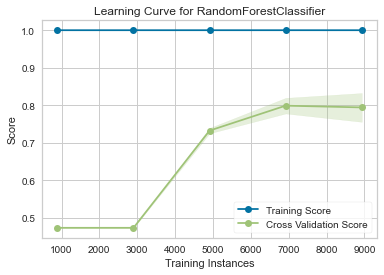

In [79]:
learning_curve(RFC1, X1, y1, scoring='accuracy')
plt.show()

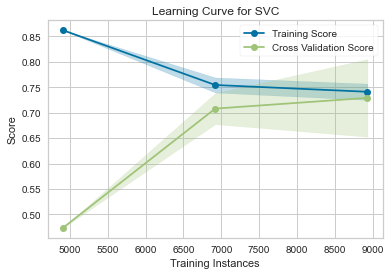

In [80]:
learning_curve(SVM1, X1, y1, scoring='accuracy')
plt.show()

In [81]:
pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                        'Normal': [RFC_score_tr1, SVM_score_tr1], 
                        'Mean Kfold' : [RFC_kfold1.mean(), SVM_kfold1.mean()]})

,Model,Normal,Mean Kfold
0,Random Forest,1.00000,0.836486
1,Support Vector,0.74342,0.740282


> Both from `learningcurves()` and **mean kfold** score are also showing the similar result here. Let's check the hyperparameter tuned model.

In [82]:
# Check overfit on hyperparameter tuned data

cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
hyper_RFC_kfold1 = cross_val_score(hyper_RFC1, X1_train, y1_train, cv = cv, scoring = 'accuracy')
hyper_SVM_kfold1 = cross_val_score(hyper_SVM1, X1_train, y1_train, cv = cv, scoring = 'accuracy')

pd.DataFrame({'Hyper RFC kfold' : hyper_RFC_kfold1.tolist(),
              'Hyper SVM kfold' : hyper_SVM_kfold1.tolist()})

,Hyper RFC kfold,Hyper SVM kfold
0,0.842105,0.751400
1,0.826428,0.718925
2,0.837626,0.760358
3,0.833147,0.737962
4,0.835386,0.760358
5,0.844345,0.742441
6,0.870101,0.781635
7,0.821948,0.750280
8,0.846585,0.758119
9,0.817265,0.718610


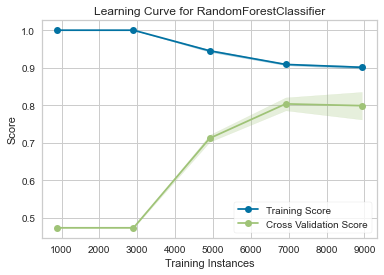

In [83]:
learning_curve(hyper_RFC1, X1, y1, scoring='accuracy')
plt.show()

> By the looks of it, the hyperparameter tuned model are showing promising result than before.

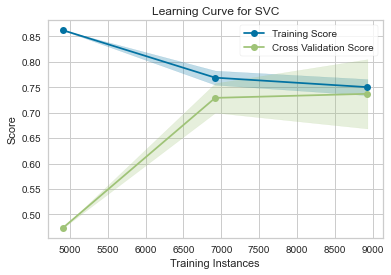

In [84]:
learning_curve(hyper_SVM1, X1, y1, scoring='accuracy')
plt.show()

In [85]:
pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                        'Hyper': [hyper_RFC_score_tr1, hyper_SVM_score_tr1], 
                        'Mean Kfold' : [hyper_RFC_kfold1.mean(), hyper_SVM_kfold1.mean()]})

,Model,Hyper,Mean Kfold
0,Random Forest,0.901333,0.837494
1,Support Vector,0.751260,0.748009


> Random Forest models are slightly overfit, but I assume it's still within a tolerable amount.

### MODEL PREDICTION AND PERFORMANCE EVALUATION - PART 2

In [86]:
# Random Forest Classifier
yp_RFC1 = hyper_RFC1.predict(X1_test)

# Support Vector Machine Classifier
yp_SVM1 = hyper_SVM1.predict(X1_test)

> Now let's check the performances of each models.

#### RANDOM FOREST CLASSIFIER

In [87]:
cm_RFC1 = confusion_matrix(y1_test, yp_RFC1)
cm_RFC1

array([[922, 244],
       [169, 898]], dtype=int64)

              precision    recall  f1-score   support

  Default No       0.85      0.79      0.82      1166
 Default Yes       0.79      0.84      0.81      1067

    accuracy                           0.82      2233
   macro avg       0.82      0.82      0.82      2233
weighted avg       0.82      0.82      0.82      2233



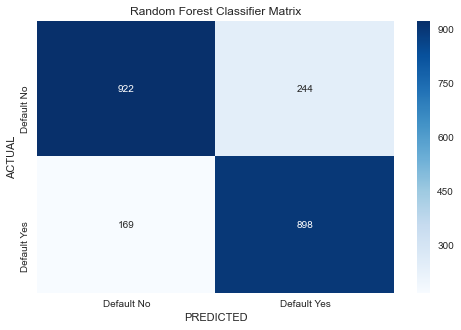

In [88]:
print(classification_report(y1_test, yp_RFC1, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_RFC1, annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Random Forest Classifier Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> Well, it rather performs better.

#### SUPPORT VECTOR MACHINE CLASSIFIER

In [89]:
cm_SVM1 = confusion_matrix(y1_test, yp_SVM1)
cm_SVM1

array([[912, 254],
       [332, 735]], dtype=int64)

              precision    recall  f1-score   support

  Default No       0.73      0.78      0.76      1166
 Default Yes       0.74      0.69      0.71      1067

    accuracy                           0.74      2233
   macro avg       0.74      0.74      0.74      2233
weighted avg       0.74      0.74      0.74      2233



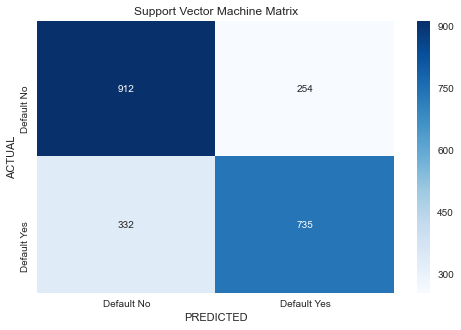

In [90]:
print(classification_report(y1_test, yp_SVM1, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_SVM1, annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Support Vector Machine Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> The SVM are also still pretty much the same. Although we can see that there are some improvement for this. Nevertheless, let's try to scale the data, maybe the outliers are taking part in this model. We'll use `RobustScaler()`.

### SCALING

> We will scale the continous data so that we'll get the same data scale as well as handling the outliers.

In [91]:
df_new2 = df_new.copy()

In [92]:
df_new2.head()

,duration,day,age,balance,campaign,contact_unknown,poutcome,education,housing_yes,pdays,deposit
0,1042,5,59,2343,1,1,3,1,1,0,1
1,1467,5,56,45,1,1,3,1,0,0,1
2,1389,5,41,1270,1,1,3,1,1,0,1
3,579,5,55,2476,1,1,3,1,1,0,1
4,673,5,54,184,2,1,3,2,0,0,1


In [93]:
df_con.columns.intersection(df_new2.columns)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays'], dtype='object')

In [94]:
for i in df_new2[['age', 'balance', 'day', 'duration', 'campaign', 'pdays']]:
    scaler = RobustScaler()
    df_new2[i] = scaler.fit_transform(df_new2[[i]])

In [95]:
df_new2.head()

,duration,day,age,balance,campaign,contact_unknown,poutcome,education,housing_yes,pdays,deposit
0,2.198324,-0.714286,1.176471,1.130517,-0.5,1,3,1,1,0.0,1
1,3.385475,-0.714286,1.000000,-0.318411,-0.5,1,3,1,0,0.0,1
2,3.167598,-0.714286,0.117647,0.453972,-0.5,1,3,1,1,0.0,1
3,0.905028,-0.714286,0.941176,1.214376,-0.5,1,3,1,1,0.0,1
4,1.167598,-0.714286,0.882353,-0.230769,0.0,1,3,2,0,0.0,1


> We've successfully scaled the data. 

### SPLIT DATA FOR MODELLING - PART 3

In [96]:
X2 = df_new2.drop(['deposit'], axis = 1)
y2 = df_new2['deposit']

In [97]:
#Split train data 80%, test data 20%

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = .8, random_state = 42)

### MODEL PREPARATION - PART 3

In [98]:
# Random Forest Classifier model with default parameter

RFC2 = RandomForestClassifier().fit(X2_train, y2_train)

# Support Vector Machine Classifier with default parameter

SVM2 = SVC(kernel = 'rbf').fit(X2_train, y2_train)

In [99]:
# Random Forest Classifier model with previously tuned hyperparameter

hyper_RFC2 = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, min_samples_leaf = 4, max_depth = 40).fit(X2_train, y2_train)

# Support Vector Machine Classifier model with previously tuned hyperparameter

hyper_SVM2 = SVC(kernel='rbf', gamma = 'scale', C = 10).fit(X2_train, y2_train)

### CROSS VALIDATION - PART 3

In [100]:
# Train data

RFC_score_tr2 = RFC2.score(X2_train, y2_train)
SVM_score_tr2 = SVM2.score(X2_train, y2_train)
hyper_RFC_score_tr2 = hyper_RFC2.score(X2_train, y2_train)
hyper_SVM_score_tr2 = hyper_SVM2.score(X2_train, y2_train)

In [101]:
# Test data

RFC_score_ts2 = RFC2.score(X2_test, y2_test)
SVM_score_ts2 = SVM2.score(X2_test, y2_test)
hyper_RFC_score_ts2 = hyper_RFC2.score(X2_test, y2_test)
hyper_SVM_score_ts2 = hyper_SVM2.score(X2_test, y2_test)

In [102]:
train_score2 = pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                            'Normal': [RFC_score_tr2, SVM_score_tr2], 
                            'Hyper' : [hyper_RFC_score_tr2, hyper_SVM_score_tr2]})

In [103]:
test_score2 = pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                           'Normal': [RFC_score_ts2, SVM_score_ts2], 
                           'Hyper' : [hyper_RFC_score_ts2, hyper_SVM_score_ts2]})

In [104]:
pd.concat([train_score2, test_score2], keys = ['Train Score', 'Test Score'])

Model    Normal     Hyper
Train Score 0   Random Forest  1.000000  0.902789
            1  Support Vector  0.816777  0.827304
Test Score  0   Random Forest  0.801164  0.807882
            1  Support Vector  0.800717  0.810569

> Again, we can still see the overfitting. But the accuracy score are higher.

In [105]:
# Check overfit on default data

cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
RFC_kfold2 = cross_val_score(RFC, X2_train, y2_train, cv = cv, scoring = 'accuracy')
SVM_kfold2 = cross_val_score(SVM, X2_train, y2_train, cv = cv, scoring = 'accuracy')

pd.DataFrame({'RFC kfold' : RFC_kfold2.tolist(),
              'SVM kfold' : SVM_kfold2.tolist()})

,RFC kfold,SVM kfold
0,0.833147,0.812990
1,0.817469,0.810750
2,0.828667,0.820829
3,0.821948,0.804031
4,0.824188,0.810750
5,0.824188,0.814110
6,0.853303,0.833147
7,0.805151,0.801792
8,0.836506,0.821948
9,0.800448,0.784753


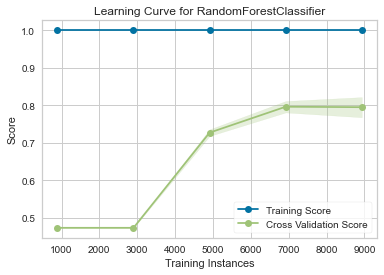

In [106]:
learning_curve(RFC2, X2, y2, scoring='accuracy')
plt.show()

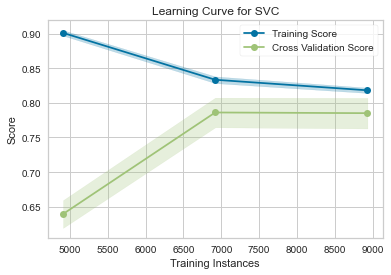

In [107]:
learning_curve(SVM2, X2, y2, scoring='accuracy')
plt.show()

In [108]:
pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                        'Normal': [RFC_score_tr2, SVM_score_tr2], 
                        'Mean Kfold' : [RFC_kfold2.mean(), SVM_kfold2.mean()]})

,Model,Normal,Mean Kfold
0,Random Forest,1.000000,0.824502
1,Support Vector,0.816777,0.811510


> Both from `learningcurves()` and **mean kfold** score are also showing the similar result here. Let's check the hyperparameter tuned model.

In [109]:
# Check overfit on hyperparameter tuned data

cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
hyper_RFC_kfold2 = cross_val_score(hyper_RFC2, X_train, y2_train, cv = cv, scoring = 'accuracy')
hyper_SVM_kfold2 = cross_val_score(hyper_SVM2, X_train, y2_train, cv = cv, scoring = 'accuracy')

pd.DataFrame({'Hyper RFC kfold' : hyper_RFC_kfold2.tolist(),
              'Hyper SVM kfold' : hyper_SVM_kfold2.tolist()})

,Hyper RFC kfold,Hyper SVM kfold
0,0.830907,0.750280
1,0.810750,0.718925
2,0.828667,0.759239
3,0.828667,0.737962
4,0.827548,0.760358
5,0.834267,0.742441
6,0.852184,0.781635
7,0.815230,0.750280
8,0.840985,0.756999
9,0.807175,0.718610


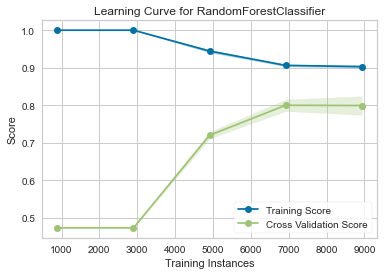

In [110]:
learning_curve(hyper_RFC2, X2, y2, scoring='accuracy')
plt.show()

> The hyperparameter tuned Random Forest model are also showing promising result just like before.

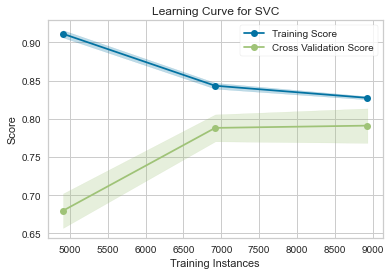

In [111]:
learning_curve(hyper_SVM2, X2, y2, scoring='accuracy')
plt.show()

In [112]:
pd.DataFrame({'Model' : ['Random Forest', 'Support Vector'], 
                        'Hyper': [hyper_RFC_score_tr2, hyper_SVM_score_tr2], 
                        'Mean Kfold' : [hyper_RFC_kfold2.mean(), hyper_SVM_kfold2.mean()]})

,Model,Hyper,Mean Kfold
0,Random Forest,0.902789,0.827638
1,Support Vector,0.827304,0.747673


> Both models are slightly overfit by using hyperparameter. But it's still tolerable.

### MODEL PREDICTION AND PERFORMANCE EVALUATION - PART 3

In [113]:
# Random Forest Classifier
yp_RFC2 = hyper_RFC2.predict(X2_test)

# Support Vector Machine Classifier
yp_SVM2 = hyper_SVM2.predict(X2_test)

> Now let's check the performances of each models.

#### RANDOM FOREST CLASSIFIER

In [114]:
cm_RFC2 = confusion_matrix(y2_test, yp_RFC2)
cm_RFC2

array([[918, 248],
       [181, 886]], dtype=int64)

              precision    recall  f1-score   support

  Default No       0.84      0.79      0.81      1166
 Default Yes       0.78      0.83      0.81      1067

    accuracy                           0.81      2233
   macro avg       0.81      0.81      0.81      2233
weighted avg       0.81      0.81      0.81      2233



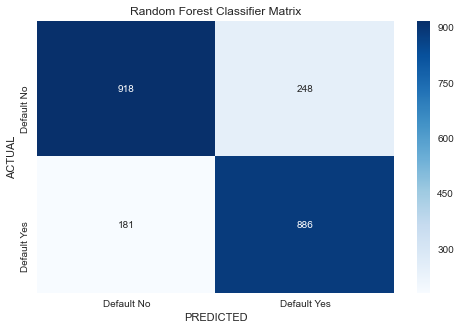

In [115]:
print(classification_report(y2_test, yp_RFC2, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_RFC2, annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Random Forest Classifier Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> Again, Random Forest still performs good.

#### SUPPORT VECTOR MACHINE CLASSIFIER

In [116]:
cm_SVM2 = confusion_matrix(y2_test, yp_SVM2)
cm_SVM2

array([[939, 227],
       [196, 871]], dtype=int64)

              precision    recall  f1-score   support

  Default No       0.83      0.81      0.82      1166
 Default Yes       0.79      0.82      0.80      1067

    accuracy                           0.81      2233
   macro avg       0.81      0.81      0.81      2233
weighted avg       0.81      0.81      0.81      2233



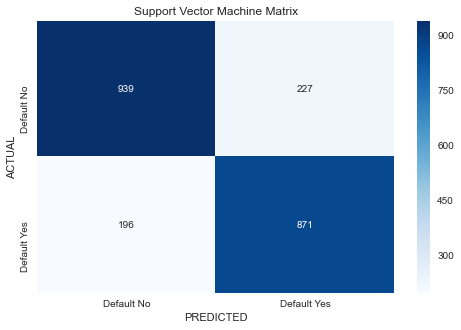

In [117]:
print(classification_report(y2_test, yp_SVM2, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_SVM2, annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Support Vector Machine Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

> Apparently after using scaler, SVM models performed far better. This means that maybe the outliers are influencing on performances of the SVM models. There are still a lot more variation we can do, but I think this far is enough. We've got our best model to predict this case.

### MODEL COMPARISON

> Finally we'll compare the result on our best models.

In [118]:
report_RFC = pd.DataFrame(classification_report(y1_test, yp_RFC1, target_names = labels, output_dict = True)).T
report_SVM = pd.DataFrame(classification_report(y2_test, yp_SVM2, target_names = labels, output_dict = True)).T

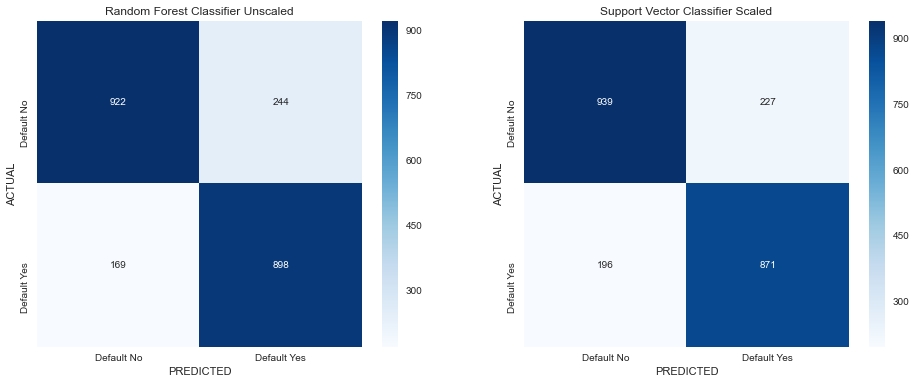

In [119]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

sns.heatmap(cm_RFC1, annot=True, fmt=".0f", ax=ax1, cmap='Blues')
sns.heatmap(cm_SVM2, annot=True, fmt=".0f", ax=ax2, cmap = 'Blues')

ax1.xaxis.set_ticklabels(labels), ax1.yaxis.set_ticklabels(labels)
ax2.xaxis.set_ticklabels(labels), ax2.yaxis.set_ticklabels(labels)

ax1.set_title('Random Forest Classifier Unscaled'), ax2.set_title('Support Vector Classifier Scaled')
ax1.set_xlabel('PREDICTED'), ax2.set_xlabel('PREDICTED')
ax1.set_ylabel('ACTUAL'), ax2.set_ylabel('ACTUAL')

plt.show()

In [120]:
pd.concat([report_RFC, report_SVM], keys = ['Random Forest Unscaled', 'Support Vector Scaled'])

precision    recall  f1-score  \
Random Forest Unscaled Default No     0.845096  0.790738  0.817014   
                       Default Yes    0.786340  0.841612  0.813038   
                       accuracy       0.815047  0.815047  0.815047   
                       macro avg      0.815718  0.816175  0.815026   
                       weighted avg   0.817020  0.815047  0.815114   
Support Vector Scaled  Default No     0.827313  0.805317  0.816167   
                       Default Yes    0.793260  0.816307  0.804619   
                       accuracy       0.810569  0.810569  0.810569   
                       macro avg      0.810287  0.810812  0.810393   
                       weighted avg   0.811041  0.810569  0.810649   

                                         support  
Random Forest Unscaled Default No    1166.000000  
                       Default Yes   1067.000000  
                       accuracy         0.815047  
                       macro avg     2233.000000  
                       weighted avg  2233.000000  
Support Vector Scaled  Default No    1166.000000  
                       Default Yes   1067.000000  
                       accuracy         0.810569  
                       macro avg     2233.000000  
                       weighted avg  2233.000000

> In conclusion, by comparing both result above we can say that **Support Vector Machine** model performed better with the **scaled data**, while the **Random Forest** model are better leave with **unscaled data**. Both are the best model algorithm to predict this dataset on their respective conditions.